In [1]:
from __init__ import  *

/home/pourya/.conda/envs/htv_reg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


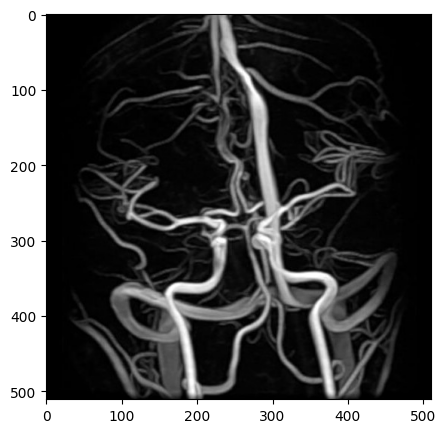

In [2]:
img = plt.imread('ExpB/data/mra.jpeg')[40:-25, 147:-206, 0] / 255
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.show()

In [3]:
device = 'cuda:3'
img_tensor = F.pad(torch.from_numpy(img)[None, None, :, :].double().to(device), (1, 1, 1, 1))
mask = torch.ones((1, 1, 512, 512)).double().to(device) 

mri_in = img_tensor[:, :, :-1, :-1]
mri = MRI(mask, device)
mri.set_h(1)
y = mri.H(mri_in)

----------- h = 4.0 -----------
iter 0, loss:7953.9082
iter 1, loss:232.7574
iter 2, loss:122.0121
iter 3, loss:97.6996
iter 4, loss:92.3159
iter 5, loss:91.4247
iter 6, loss:91.3801
iter 7, loss:91.3828
iter 8, loss:91.3546
iter 9, loss:91.3277
iter 10, loss:91.315
iter 11, loss:91.3119
iter 12, loss:91.3117
iter 13, loss:91.3116
iter 14, loss:91.3111
iter 15, loss:91.3107
iter 16, loss:91.3105
iter 17, loss:91.3104
iter 18, loss:91.3104
iter 19, loss:91.3104
iter 20, loss:91.3104
iter 21, loss:91.3103
iter 22, loss:91.3103
iter 23, loss:91.3103
iter 24, loss:91.3103
iter 25, loss:91.3103
iter 26, loss:91.3103
iter 27, loss:91.3103
iter 28, loss:91.3103
iter 29, loss:91.3103
iter 30, loss:91.3103
iter 31, loss:91.3103
iter 32, loss:91.3103
iter 33, loss:91.3103
iter 34, loss:91.3103
iter 35, loss:91.3103
iter 36, loss:91.3103
iter 37, loss:91.3103
final loss : 91.3103


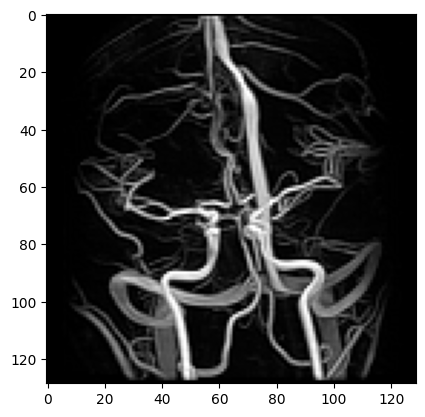

In [4]:
mrs = MultiResSolver('fm', 'htv', lmbda =0, mask=mask, h_init=4, N_scales=1, range_r=512, device=device, verbose=True, toi=1e-6)
mrs.solve_fm(y)
c_2_exact = mrs.sols[0]

plt.imshow(c_2_exact.cpu()[0, 0], cmap='gray')
plt.show()

iter 0, loss:7953.9082
iter 20, loss:302.1758
iter 40, loss:302.1758
iter 60, loss:302.1758
iter 80, loss:302.1758
iter 99, loss:302.1758


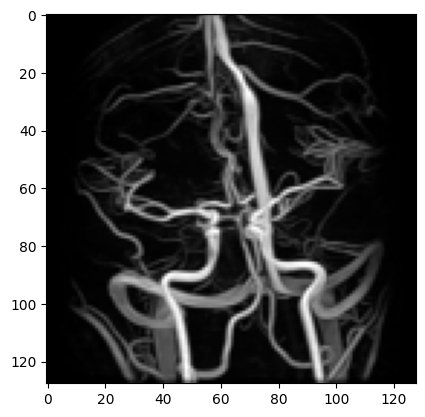

In [5]:
mri = MRIPixel(mask, device)

mri.set_h(4)

c_k = torch.zeros((1, 1, 128, 128)).double().to(device)
d_k = torch.zeros((1, 1, 128, 128)).double().to(device)

alpha = 0.0625
t_k = 1 
toi = 1e-6

for i in range(100): 

    if (i%20==0 or i==100-1) : 
        loss = (torch.abs(y - (mri.H(c_k)))**2).sum() / 2
        print('iter ' + str(i) + ', loss:' + str(np.round(loss.item(), 4)))

    c_kp1 = d_k + alpha * mri.Ht(y - mri.H(d_k))
    t_kp1 = (1 + np.sqrt(4*t_k**2+1)) / 2
    d_kp1 = c_kp1  + (t_k - 1) / t_kp1 * (c_kp1 - c_k)        

    err_rel = torch.norm(c_k - c_kp1, p='fro') / max((torch.norm(c_k, p='fro')).item(), 1e-10)

    c_k = c_kp1
    d_k = d_kp1
    t_k = t_kp1

    #if err_rel < toi: 
     #   break      

c_pixel = torch.clip(c_k, 0, 1)

plt.imshow(c_pixel.cpu()[0, 0], cmap='gray')
plt.show()

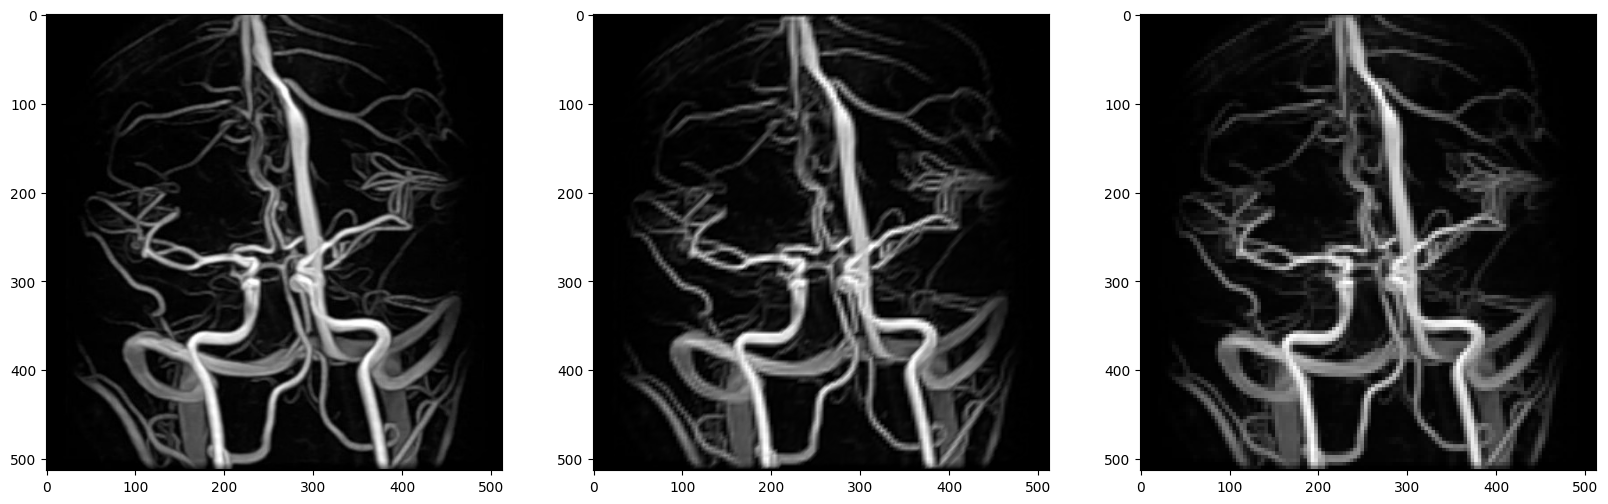

In [6]:
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(img_tensor.cpu()[0, 0], cmap='gray')
plt.subplot(132)
img_exact = mrs.sam.upsample(mrs.sam.upsample(c_2_exact))
plt.imshow((img_exact).abs().cpu()[0, 0], cmap='gray')
plt.subplot(133)
img_pixel = F.pad(mri.upsample(mri.upsample(c_pixel)), (0, 1, 0, 1))
plt.imshow((img_pixel).abs().cpu()[0, 0], cmap='gray')
plt.show()

In [7]:
psnr_exact = compute_PSNR(img_exact, img_tensor, 1)
psnr_pixel = compute_PSNR(img_pixel, img_tensor, 1)
print(psnr_exact, psnr_pixel)

30.66512721199721 26.139118109656046
